In [0]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision

from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


In [0]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# https://www.kaggle.com/paultimothymooney/blood-cells
train_path = '/content/drive/My Drive/Fruits_Dataset/dataset3/Training'
valid_path = '/content/drive/My Drive/Fruits_Dataset/dataset3/Test'

In [0]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [0]:
# useful for getting number of classes
folders = glob(train_path + '/*')

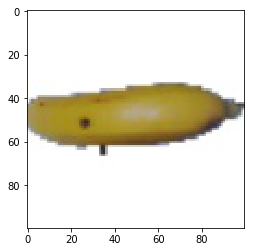

In [53]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [0]:
# add preprocessing layer to the front of Inception
vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [0]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [0]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
#x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [0]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [62]:
# view the structure of the model
model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [0]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [65]:
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 1289 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -98.939 max: 151.061


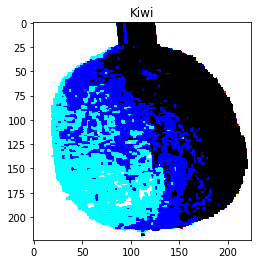

In [66]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [67]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3839 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.


In [68]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)


Epoch 1/5
119/119 [==============================] - 3242s 27s/step - loss: 6.2123 - acc: 0.6076 - val_loss: 5.8806 - val_acc: 0.6352
Epoch 2/5
119/119 [==============================] - 3223s 27s/step - loss: 5.9273 - acc: 0.6323 - val_loss: 5.8985 - val_acc: 0.6340
Epoch 3/5
119/119 [==============================] - 3239s 27s/step - loss: 5.9221 - acc: 0.6323 - val_loss: 5.9625 - val_acc: 0.6301
Epoch 4/5
119/119 [==============================] - 3234s 27s/step - loss: 5.9397 - acc: 0.6315 - val_loss: 5.8215 - val_acc: 0.6388
Epoch 5/5
119/119 [==============================] - 3238s 27s/step - loss: 5.9062 - acc: 0.6336 - val_loss: 5.7574 - val_acc: 0.6428


In [0]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

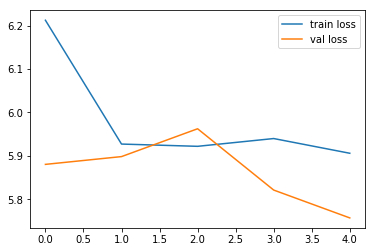

In [69]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

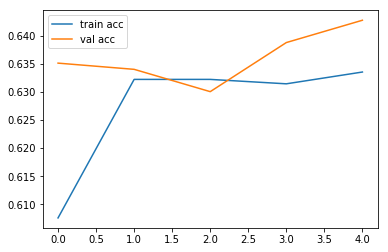

In [70]:
# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()